In [25]:
import time
import datetime
import os
import yaml
import math
import sys
import gurobipy
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

print(f"python version: {sys.version}")
print(f"gurobipy version: {gurobipy.gurobi.version()}")


python version: 3.9.18 (main, Sep 11 2023, 08:38:23) 
[Clang 14.0.6 ]
gurobipy version: (11, 0, 0)


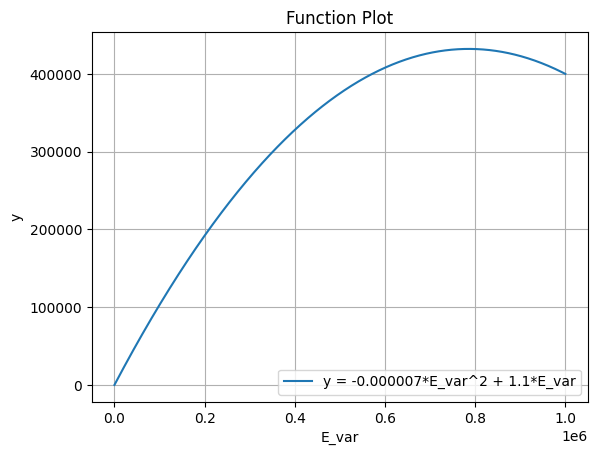

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def func(E_var):
    return -0.0000007 * E_var**2 + 1.1 * E_var

# 生成 x 值（E_var 的范围）
E_var = np.linspace(0, 1000000, 1000)

# 计算对应的 y 值
y = func(E_var)

# 绘制函数图形
plt.plot(E_var, y, label='y = -0.000007*E_var^2 + 1.1*E_var')
plt.xlabel('E_var')
plt.ylabel('y')
plt.title('Function Plot')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# 直接添加已知的相对路径到 sys.path
sys.path.append('../../') 
from path_config import INSTANCES_DIR
def load_specific_yaml(filename):
    """
    加載指定的 YAML 檔案。
    
    Parameters:
    filename (str): 在 instances 資料夾中的 YAML 檔案名。
    
    Returns:
    dict: YAML 檔案內容。
    """
    file_path = os.path.join(INSTANCES_DIR, filename)
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

config = load_specific_yaml('instance_F_3.yaml')
# config['V'] = [[value[0] * 100] for value in config['V']]
config

{'A_opponent_bar': [96],
 'B': [[2], [1], [1]],
 'C': [3, 2, 2],
 'D': [[59.2, 32.2, 35.69], [54.49, 64.54, 64.76]],
 'D_comp': [[23.32], [59.46]],
 'F': [6, 6, 5],
 'H': [39, 36],
 'M': 1000000,
 'U_L': [14, 8, 14],
 'U_LT': [[1], [5], [4]],
 'U_T': [5],
 'V': [[6], [18], [5]],
 'i_amount': 2,
 'j_amount': 3,
 'k_amount': 1,
 'l_amount': 1,
 'lambda_for_G': 6e-06}

In [27]:
I = set(range(0, config['i_amount']))  
J = set(range(0, config['j_amount']))  
K = set(range(0, config['k_amount']))  
L = set(range(0, config['l_amount']))  
'''
Decision Variables
===============================
y : Whether location j build facility or not, Dim: (j) , BINARY
x : The amount of resource k allocated to location j, Dim: (j,k), CONTINUOUS
aX : Extra attractiveness allocated to location j, Dim: (j), CONTINUOUS
===============================

Other Variables
u : Utility of facility j to customer point i, Dim:(i, j), CONTINUOUS
P : Probability of customer i choosing facility j, Dim : (i, j), CONTINUOUS
TA : Total Attractiveness for customer location i, Dim : (i), CONTINUOUS
===============================
'''

'\nDecision Variables\n===============================\ny : Whether location j build facility or not, Dim: (j) , BINARY\nx : The amount of resource k allocated to location j, Dim: (j,k), CONTINUOUS\naX : Extra attractiveness allocated to location j, Dim: (j), CONTINUOUS\n===============================\n\nOther Variables\nu : Utility of facility j to customer point i, Dim:(i, j), CONTINUOUS\nP : Probability of customer i choosing facility j, Dim : (i, j), CONTINUOUS\nTA : Total Attractiveness for customer location i, Dim : (i), CONTINUOUS\n===============================\n'

In [28]:
# Initialize the model
model = Model("Competitive Facility Location")
model.setParam('NumericFocus', 3)
y = model.addVars(J, vtype=GRB.BINARY, name="y") #3.14
x = model.addVars(J, K, vtype=GRB.CONTINUOUS, name="x", lb=0, ub=100000) # 3.12
aX = model.addVars(J, vtype=GRB.CONTINUOUS, name="aX", lb=0, ub=100000) # 3.13

u = model.addVars(I, J, vtype=GRB.CONTINUOUS, name="utility(u)", lb=0, ub=100000) # utility var(3.5)
P = model.addVars(I, J, vtype=GRB.CONTINUOUS, name="P, utility vs TA ratio", lb=0.0, ub=1.0) # Probability of i choosing j
TA = model.addVars(I, vtype=GRB.CONTINUOUS, name="TA", lb=0.00000001, ub=100000000)
TAi_lambda = model.addVars(I, vtype=GRB.CONTINUOUS, name="negative TAi*lambda(e's power)", lb= -1000000, ub= -0.0000001) #-lambda*TAi
G_exp_vars = model.addVars(I, vtype=GRB.CONTINUOUS, name="G_exp_vars", lb=0.0001, ub=0.9999) #e^-(lambda*TAi), ub=0.5

model.update()

model.addConstrs((x[j, k] <= config['U_LT'][j][k] * y[j] for j in J for k in K), "(3.1) Resource only for built facility, and amount of type k for facility j is limit at U_LT[j, k]")
model.addConstrs((quicksum(x[j, k] for j in J) <= config['U_T'][k] for k in K), "(3.2) The total amount of resource k is U_T[k]")
model.addConstrs((quicksum(x[j, k] for k in K) <= config['U_L'][j] for j in J), "(3.3) The max resource sum for facility j is U_L[j]")
model.addConstrs((aX[j] <= config['M'] * y[j] for j in J), "(3.4) Extra Attractiveness Limit")

model.addConstrs((u[i, j] == ((quicksum(config['V'][j][k] * x[j, k] for k in K) + aX[j]) / (config['D'][i][j]**2)) for i in I for j in J), "(3.5) utility for facility j to customer i")
model.addConstrs((u[i, j] == P[i, j] * TA[i] for i in I for j in J), "(3.8) calculate P by uij/TAi, 分母要是常數所以用乘的")
## TA的限制式, 因為不能讓 G_exp中 addGenConstrExp內的變數為多個變數的線性組合所以要另外創TA變數
model.addConstrs((TA[i] == quicksum(u[i, j] for j in J) + (quicksum(config['A_opponent_bar'][l] / (config['D_comp'][i][l]**2) for l in L)) for i in I), "(3.7) calculate total TA by u and A_bar")

## G的計算
# def G(tai):
#     return 1 - np.exp(-config['lambda_for_G'] * tai)
model.addConstrs((TAi_lambda[i] == (-config['lambda_for_G'] * TA[i]) for i in I), "negative tai*lambda constr")
# Gurobi無法直接在目標式有exponential
for i in I:
    model.addGenConstrExpA(TAi_lambda[i], G_exp_vars[i], math.e, name=f"G_exp_constr_{i}")



# Objective function: Maximize profit by attracting customers - costs
objective = ((quicksum(config['H'][i] * (1 - G_exp_vars[i]) * (quicksum(P[i, j] for j in J)) for i in I)) \
          - (quicksum(config['F'][j] * y[j] + config['C'][j] * aX[j] + quicksum(config['B'][j][k] * x[j, k] for k in K) for j in J)))
model.setObjective(objective, GRB.MAXIMIZE)


model.feasRelaxS(0, True, False, False)
# Solve and Output
model.optimize()
if model.status == GRB.OPTIMAL:
    print("Optimal solution found.")
else:
    print("No optimal solution found.")
    model.computeIIS()
    model.write("model.ilp")
    model.write("model_iis.mps")
    print("IIS written to file.")



Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 27 columns and 48 nonzeros
Model fingerprint: 0x0d7cdfc9
Model has 6 quadratic objective terms
Model has 6 quadratic constraints
Model has 2 general constraints
Variable types: 24 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [7e+01, 8e+01]
  Bounds range     [1e-08, 1e+08]
  RHS range        [3e-02, 1e+01]
Presolve added 0 rows and 47 columns
Presolve time: 0.00s
Presolved: 57 rows, 81 columns, 287 nonzeros
Presolved model has 2 SOS constraint(s)
Presolved model has 12 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 78 conti

In [29]:
for var in model.getVars():
    print(f"{var.varName} = {var.x}")
print("")

y[0] = -0.0
y[1] = 1.0
y[2] = -0.0
x[0,0] = 0.0
x[1,0] = 5.0
x[2,0] = 0.0
aX[0] = 0.0
aX[1] = 69223.89362483048
aX[2] = 0.0
utility(u)[0,0] = 0.0
utility(u)[0,1] = 66.85109913277888
utility(u)[0,2] = 0.0
utility(u)[1,0] = 0.0
utility(u)[1,1] = 16.640346808663633
utility(u)[1,2] = 0.0
P, utility vs TA ratio[0,0] = 0.0
P, utility vs TA ratio[0,1] = 0.9973663364424471
P, utility vs TA ratio[0,2] = 0.0
P, utility vs TA ratio[1,0] = 0.0
P, utility vs TA ratio[1,1] = 0.998370887940263
P, utility vs TA ratio[1,2] = 0.0
TA[0] = 67.02762735228585
TA[1] = 16.667500033974648
negative TAi*lambda(e's power)[0] = -0.0004021657641137151
negative TAi*lambda(e's power)[1] = -0.00010000500020384789
G_exp_vars[0] = 0.9996051760411743
G_exp_vars[1] = 0.9999000000001264



# References

## G calculation substitude exponential

https://www.gurobi.com/documentation/10.0/refman/py_model_agc_exp.html

https://support.gurobi.com/hc/en-us/community/posts/360077178491-Build-an-objective-function-with-Log-and-Exponential-inside-

https://support.gurobi.com/hc/en-us/community/posts/10481250723217-How-to-add-log-and-exponential-term-in-objective-function
